# MS 274 Homework 8
In this homework, you will analyze and interpret sea ice trends in two rapidly changing marginal seas in the Antarctic Ocean: the Weddell Sea and the Amundsen Sea. 

#### Import the modules

In [1]:
# import the numpy, matplotlib, netcdf, os, and datetime modules
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import os
import datetime as dt
import requests

## Problem 8.1: Download Southern Hemisphere Sea Ice Data
To begin this assignment, download all of the available sea ice concentration date from the National Snow and Ice Data Center.

#### Define a data path and download the data
In the code block below, define a `file_folder` where you will download the sea ice data. Be sure this folder exists on your file system.

In [4]:
# define a path to your raster files folder 
download_folder = "D:\Remote sensing\HW_8\Data"

Next, copy over the **Download Data from NSIDC** notebook from Lab 8 and modify the code to download all monthly sea ice concentration data for the southern hemisphere.

In [7]:
# hemisphere and hemisphere code
hemisphere = 'south'
hemisphere_code = 'sh'

# initial satellite code
sat_code = 'n07'

# define the base url
base_url = 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/'+hemisphere+'/monthly/'

# make a list of URls corresponding to the file date
file_urls = []
for year in range(1979,2023):
    for month in range(1,13):

        # update satellite code when different satellites are used
        if year==1987 and month==8:
            sat_code = 'f08'
        if year==1992 and month==1:
            sat_code = 'f11'
        if year==1995 and month==10:
            sat_code = 'f13'
        if year==2008 and month==1:
            sat_code = 'f17'
        
        yr = str(year)
        mo = '{:02d}'.format(month)
        file_name = 'seaice_conc_monthly_'+hemisphere_code+'_'+yr+mo+'_'+sat_code+'_v04r00.nc'
        file_urls.append(base_url+'/'+file_name)

for i in range(len(file_urls)):
    url = file_urls[i]
    
    file_name = url.split('/')[-1]
    if file_name not in os.listdir(download_folder):
    
        print('Downloading '+file_name+' (file '+str(i+1)+' of '+str(len(file_urls))+')')
    
        output_file = os.path.join(download_folder,file_name)
    
        with requests.get(url, stream=True, allow_redirects=True) as r:
            r.raise_for_status()
            with open(output_file, 'wb') as f:                   
                for chunk in r.iter_content(chunk_size=8192):   
                    f.write(chunk)

## Problem 8.2: Make Timeseries of Sea Ice in the Weddell Sea and the Amundsen Sea
Chapter 9 of the most recent IPCC Assessment Report, found [HERE](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-9/), describes recent trends in the Weddell Sea and the Amundsen Sea. These two regions can be roughly defined by the boxes with the extents defined below:

In [5]:
# Weddell Sea
min_x_weddell = 1748344
min_y_weddell = -2139981
max_x_weddell = 2626968
max_y_weddell = -581133

# Amundsen Sea
min_x_amundsen = -1635773
min_y_amundsen = -1816875
max_x_amundsen = -1352346
max_y_amundsen = -558459

The above coordinates are provided in the *NSIDC Sea Ice Polar Stereographic South* projection (EPSG: 3412). This is the same projection as for the x and y grids distriburted with the Southern Hemisphere sea ice data.

### Create two timeseries
Using the files downloaded in Problem 8.1, generate two timeseries of sea ice area - one for the Weddell Sea and one for the Amundsen Sea.

In [7]:
#this is four loop for ws
#first define the bounds for ws
# make a file path to one of the nc files
file_path = os.path.join(download_folder, 'seaice_conc_monthly_sh_197901_n07_v04r00.nc' )
# open the file and read in the sea ice variable to a 2D numpy grid
ds = nc4.Dataset(file_path)
x = np.array(ds.variables['xgrid'])
y = np.array(ds.variables['ygrid'])
sea_ice = np.array(ds.variables['nsidc_nt_seaice_conc_monthly'])
ds.close()

# find the indices of the box bounds in the x and y grids
min_col_WS = np.argmin(np.abs(x-min_x_weddell))
max_col_WS = np.argmin(np.abs(x-max_x_weddell))
max_row_WS = np.argmin(np.abs(y-min_y_weddell))
min_row_WS = np.argmin(np.abs(y-max_y_weddell))

# make a sorted file list of all the sea ice nc files
file_list_sea_ice = []

# write a for loop to loop through the files
for file_name_sea_ice in os.listdir(download_folder):
    if file_name_sea_ice[-3:] == '.nc':
        if 'seaice' in file_name_sea_ice:
            file_list_sea_ice.append(file_name_sea_ice) #don't really need the if seaice but im keeping it

# sort the file list
file_list_sea_ice.sort()

# Make empty lists to store dates and sea ice values
date_list_WS = []
seaice_values_WS = []

# # loop through all of the files in the file list
for file_name_sea_ice in file_list_sea_ice:
    # Split the file name and retrieve the year and month strings
    file_parts = file_name_sea_ice.split('_')
    year = file_parts[4][:4]  # First 4 characters are the year
    month = file_parts[4][4:6]  # Characters 5 and 6 are the month
    
    # Make a string for the middle day of the month (15)
    day = '01'
    
    # Join the year, month, and day strings with dashes and add to the date_list
    date_string = year + '-' + month + '-' + day 

    # make a file path to one of the nc files
    file_path = os.path.join(download_folder, file_name_sea_ice)

    # open the file and read in the sea ice variable to a 2D numpy grid
    ds = nc4.Dataset(file_path)
    sea_ice_WS = np.array(ds.variables['nsidc_nt_seaice_conc_monthly'])
    ds.close()
    #does not incldue x and y because of chunk 42
    # take only the "first timestep" of the seaice grid
    sea_ice_WS = sea_ice_WS[0, :, :]

    # subset the grid and find the area of sea ice in the subset
    sea_ice_subset_WS = sea_ice_WS[min_row_WS:max_row_WS, min_col_WS:max_col_WS]

    # compute the total area of seaice in this grid
    sea_ice_raveled_WS = sea_ice_subset_WS.ravel()
    sea_ice_filtered_WS = sea_ice_raveled_WS[sea_ice_raveled_WS < 2]
    area=np.sum(sea_ice_filtered_WS*25*25)
    # if the sea ice area value is valid (>0), add the date to the date list
    # and the value to the value list 
    if area > 0: 
        date_list_WS.append(date_string)
        seaice_values_WS.append(area)



# After the loop, convert the date_list to a NumPy array with dtype='datetime64'
date_array_WS = np.array(date_list_WS, dtype='datetime64')

In [8]:
#this is four lopp for AM
#first define the bounds for AM
# make a file path to one of the nc files
file_path = os.path.join(download_folder, 'seaice_conc_monthly_sh_197901_n07_v04r00.nc' )
# open the file and read in the sea ice variable to a 2D numpy grid
ds = nc4.Dataset(file_path)
x = np.array(ds.variables['xgrid'])
y = np.array(ds.variables['ygrid'])
sea_ice = np.array(ds.variables['nsidc_nt_seaice_conc_monthly'])
ds.close()

# find the indices of the box bounds in the x and y grids
min_col_AM = np.argmin(np.abs(x-min_x_amundsen))
max_col_AM = np.argmin(np.abs(x-max_x_amundsen))
max_row_AM = np.argmin(np.abs(y-min_y_amundsen))
min_row_AM = np.argmin(np.abs(y-max_y_amundsen))

# make a sorted file list of all the sea ice nc files
file_list_sea_ice = []

# write a for loop to loop through the files
for file_name_sea_ice in os.listdir(download_folder):
    if file_name_sea_ice[-3:] == '.nc':
        if 'seaice' in file_name_sea_ice:
            file_list_sea_ice.append(file_name_sea_ice) #don't really need the if seaice but im keeping it

# sort the file list
file_list_sea_ice.sort()

# Make empty lists to store dates and sea ice values
date_list_AM = []
seaice_values_AM = []

# # loop through all of the files in the file list
for file_name_sea_ice in file_list_sea_ice:
    # Split the file name and retrieve the year and month strings
    file_parts = file_name_sea_ice.split('_')
    year = file_parts[4][:4]  # First 4 characters are the year
    month = file_parts[4][4:6]  # Characters 5 and 6 are the month
    
    # Make a string for the middle day of the month (15)
    day = '01'
    
    # Join the year, month, and day strings with dashes and add to the date_list
    date_string = year + '-' + month + '-' + day 

    # make a file path to one of the nc files
    file_path = os.path.join(download_folder, file_name_sea_ice)

    # open the file and read in the sea ice variable to a 2D numpy grid
    ds = nc4.Dataset(file_path)
    sea_ice_AM = np.array(ds.variables['nsidc_nt_seaice_conc_monthly'])
    ds.close()
    #does not incldue x and y because of chunk 42
    # take only the "first timestep" of the seaice grid
    sea_ice_AM = sea_ice_AM[0, :, :]

    # subset the grid and find the area of sea ice in the subset
    sea_ice_subset_AM = sea_ice_AM[min_row_AM:max_row_AM, min_col_AM:max_col_AM]

    # compute the total area of seaice in this grid
    sea_ice_raveled_AM = sea_ice_subset_AM.ravel()
    sea_ice_filtered_AM = sea_ice_raveled_AM[sea_ice_raveled_AM < 2]
    area=np.sum(sea_ice_filtered_AM*25*25)
    # if the sea ice area value is valid (>0), add the date to the date list
    # and the value to the value list 
    if area > 0: 
        date_list_AM.append(date_string)
        seaice_values_AM.append(area)



# After the loop, convert the date_list to a NumPy array with dtype='datetime64'
date_array_AM = np.array(date_list_AM, dtype='datetime64')

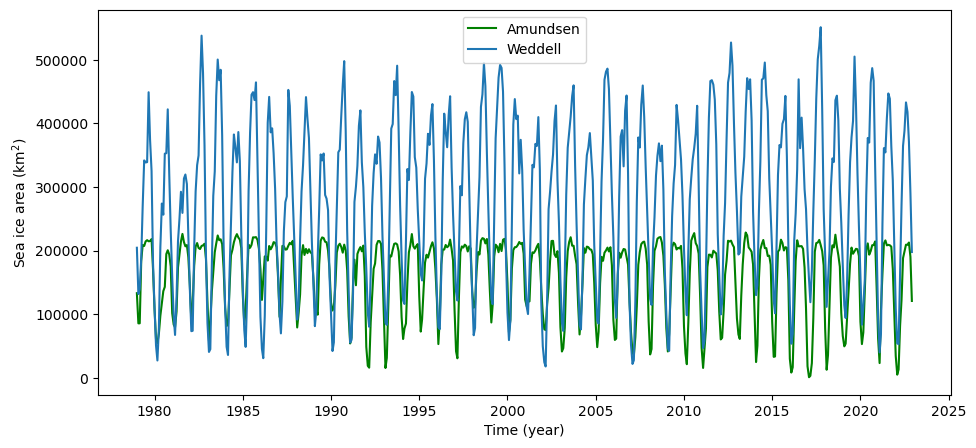

In [20]:
#now create timeseries 
fig = plt.figure(figsize=(11,5))

# make a plot of the sea ice values vs the date array
plt.plot(date_array_AM, seaice_values_AM, label = 'Amundsen', color = 'green')
plt.plot(date_array_WS, seaice_values_WS, label = "Waddell")

# label the y axis
plt.ylabel('Sea ice area (km$^2$)')
plt.xlabel('Time (year)')

# show the figure
plt.legend()
plt.show()

## Problem 8.3: Subset the timeseries to March
In the southern hemisphere, the sea ice minimum occurs around March of each year. Create two timeseries subsets from the Weddell and Amundsen timeseries for March values only. Store the dates as decimal years so that trends can be computed in the next step

In [10]:
# subset set for march first for WS
mar_dates_WS = []
mar_values_WS = []

# loop through the full date array
for i in range(len(date_array_WS)):
    
    date = date_array_WS[i]
    value = seaice_values_WS[i]
    
    # convert the date to a datetime object
    date_datetime = date.astype(dt.datetime)
    
    # if the month is September, add it and its value to the list
    if date_datetime.month == 3: #in[3,4,5]
        mar_dates_WS.append(date)
        mar_values_WS.append(value)
                            
# subset set for march first for AM
mar_dates_AM = []
mar_values_AM = []

# loop through the full date array
for i in range(len(date_array_AM)):
    
    date = date_array_AM[i]
    value = seaice_values_AM[i]
    
    # convert the date to a datetime object
    date_datetime = date.astype(dt.datetime)
    
    # if the month is September, add it and its value to the list
    if date_datetime.month == 3: #in[3,4,5]
        mar_dates_AM.append(date)
        mar_values_AM.append(value)

In [11]:
#in decimal format 
# define a function to turn a date, given by year, month, and day, into a decimal year
def YMD_to_DecYr(year,month,day):
    
    # define a date object using the datetime module
    date = dt.datetime(year,month,day)

    # define the start in ordinal units (days since ...)
    start = dt.date(date.year, 1, 1).toordinal()

    # compute the year_length in ordinal units (365 or 366)
    year_length = dt.date(date.year+1, 1, 1).toordinal() - start

    # compute the fraction based on the date
    decimal_fraction = float(date.toordinal() - start) / year_length

    # compute the decimal year
    dec_yr = year+decimal_fraction
    return(dec_yr)
    
#WS in march
mar_decyrs_WS = []
# loop through the sept date values and fill in the decimal years list
for date in mar_dates_WS:
    year = int(str(date) [:4])
    month = int(str(date) [5:7])
    day = int(str(date) [8:10])
    decyr = YMD_to_DecYr(year,month,day)
    mar_decyrs_WS.append(decyr)
    
#AM in march
mar_decyrs_AM = []
# loop through the sept date values and fill in the decimal years list
for date in mar_dates_AM:
    year = int(str(date) [:4])
    month = int(str(date) [5:7])
    day = int(str(date) [8:10])
    decyr = YMD_to_DecYr(year,month,day)
    mar_decyrs_AM.append(decyr)

## Problem 8.4: Compute the March trends of Sea Ice in the Weddell and Amundsen Seas
Compute the trends in sea ice area in March for the Weddell Sea and the Amundsen Sea. (Be sure to convert the dates to decimal years if you have not done so already.)

In [13]:
# use numpy's polyfit function to compute the weddell trend
p = np.polyfit(mar_decyrs_WS, mar_values_WS, 1)
print(p)

# the slope value is the first value
slope_WS = p[0]

# the intercept is the second value
intercept_WS = p[1]

# compute the values of the best fit line 
# for the september decyr values
best_fit_line_WS = slope_WS*np.array(mar_decyrs_WS) + intercept_WS

[ 8.74409955e+02 -1.66284768e+06]


In [14]:
# use numpy's polyfit function to compute the amundsen trend
p = np.polyfit(mar_decyrs_AM, mar_values_AM, 1)
print(p)

# the slope value is the first value
slope_AM = p[0]

# the intercept is the second value
intercept_AM = p[1]

# compute the values of the best fit line 
# for the september decyr values
best_fit_line_AM = slope_AM*np.array(mar_decyrs_AM) + intercept_AM

[-1.51308703e+03  3.09921013e+06]


## Problem 8.5: Plot the March Sea Ice Timeseries for the Weddell Sea and Amundsen Sea 
Plot the March sea ice timeseries on two separate plots. In addition, plot the trend lines and include a label in the legend which shows the trend in sea ice area. Be sure to add labels to the axis and gridlines to your plot.

<function matplotlib.pyplot.show(close=None, block=None)>

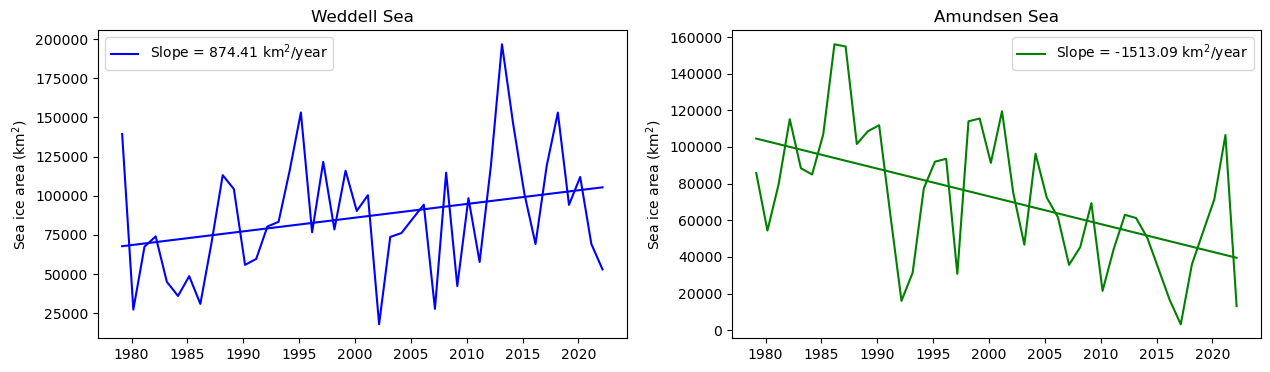

In [19]:
# make a figure with two subplot to show the timeseries and trends
fig = plt.figure(figsize=(15,4))

# make a plot of the sea ice values vs the date array
plt.subplot(1,2,1)
plt.plot(mar_dates_WS, mar_values_WS, color = 'blue')
plt.plot(mar_dates_WS, best_fit_line_WS, 
         label = 'Slope = ' + '{:.2f}'.format(slope_WS) + ' km$^2$/year', color = 'blue')
plt.legend()
plt.title("Weddell Sea")
plt.ylabel('Sea ice area (km$^2$)')

plt.subplot(1,2,2)
plt.plot(mar_dates_AM, mar_values_AM, color = 'green')
plt.plot(mar_dates_AM, best_fit_line_AM, 
         label = 'Slope = ' + '{:.2f}'.format(slope_AM) + ' km$^2$/year', color = 'green')
plt.title("Amundsen Sea")
plt.ylabel('Sea ice area (km$^2$)')

#legend 
plt.legend()

# show the figure
plt.show

## Problem 8.6: Interpret the Changes in Antarctic Sea Ice
Comment on the trends observed in the Weddell vs Amundsen sea. How do they compare? 

The most recent IPCC Assessment Report, Chapter 9 provides a synopsis of recent research on Antarctic sea ice (in addition to many other topics). The chapter can be accessed in PDF form from a link [HERE](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-9/). What does this report say about how these trends contribute to the overall trend in Antarctic sea ice? What is one reason why Antarctic sea ice might be changing?

In the Weddell sea, sea ice is increasing as time increases but in the Amundsen sea, sea ice is decreasing as time decreases. The most recent IPCC assessment report states that there are regionally opposing trends and large interannual variability, which results in no significant trend in satellite-observed sea ice area from 1979 to 2020. One reason why sea ice is can increase in Antarctic is that the southern winds are increasing, which pushes the sea ice further out, causes the total area to expand. One hypothesis would be that the Weddell sea experiences these southern winds more frequently, causing sea ice to expand compared to Amundesen that does not see the expanision over time. 